# **Load The Data and Dependencies**

In [ ]:
#install libraries
!pip install -q keras

#imports
import tensorflow as tf
import keras
from keras import backend as K
from keras.engine.topology import Layer
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator

import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
import os
import pandas as pd
import random
from google.colab.patches import cv2_imshow

In [ ]:
#run this cell if you are importing the libraries from google drive
from google.colab import drive

#import data library
drive.mount('/content/drive')

path = '/content/drive/MyDrive/myData' #folder with all the data
labelFile = '/content/drive/MyDrive/labels.csv' #CSV file with the labels and class names

In [ ]:
#run this cell if you are importing the libraries localy

path = "myData" #folder with all the data
labelFile = "labels.csv" #CSV file with the labels and class names

In [ ]:
#Set the parameters
batchSize = 200 #set the batch size
stepsPerEpoch = 28 #set epoch steps
epochs = 10 #set epochs
imageDimesions = (32,32,3) #set the dimensions of the image 
testRatio = 0.2 #set the test ratio
validationRatio = 0.2 #set the validation ratio

In [ ]:
#Import all the images
currentClass = 0 #number of current class
imagesPerClass = 0 #number of images per class
imageLimit = 500 #set the limit of images per class

images = [] #list of all images
classes = [] #list of all labels per image                           
samples = [] #list of the number of samples per class

classList = os.listdir(path) #list of all the classes
numberOfClasses = len(classList) #number of classes

print("Total Classes Detected:",numberOfClasses)
print("Importing Classes.....")

for x in range (0, numberOfClasses):
    imageList = os.listdir(path+"/"+str(currentClass))
    for y in imageList:
        currentImage = cv2.imread(path+"/"+str(currentClass)+"/"+y)
        images.append(currentImage)
        classes.append(currentClass)
        imagesPerClass += 1
        if (imagesPerClass == imageLimit):
          break
    print("Images in class", currentClass, ": ", imagesPerClass)
    samples.append(imagesPerClass)
    currentClass += 1
    imagesPerClass = 0
    
images = np.array(images)
classes = np.array(classes)

# **Pre-Process The Images**

In [ ]:
#Split the data
X_train, X_test, y_train, y_test = train_test_split(images, classes, test_size = testRatio)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size = validationRatio)

#Show the data set shape
print("Data Shapes")
print("Train", end = "");print(X_train.shape, y_train.shape)
print("Test", end = "");print(X_test.shape, y_test.shape)
print("Validation", end = "");print(X_validation.shape, y_validation.shape)
 
#Read the CSV file with the label names
data = pd.read_csv(labelFile)
print("data shape ", data.shape, type(data))

Data Shapes
Train(10914, 32, 32, 3) (10914,)
Test(3411, 32, 32, 3) (3411,)
Validation(2729, 32, 32, 3) (2729,)
data shape  (43, 2) <class 'pandas.core.frame.DataFrame'>


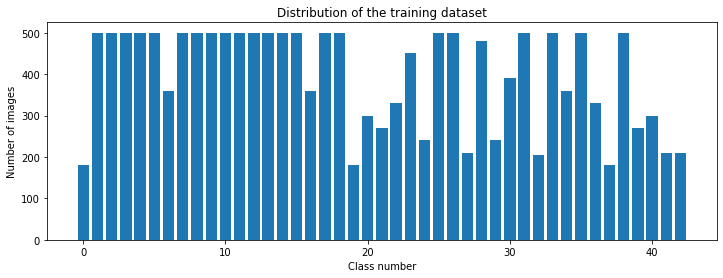

In [ ]:
#Display the distribution of data in all classes
plt.figure(figsize=(12, 4))
plt.bar(range(0, numberOfClasses), samples)
plt.title("Distribution of the training dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

In [ ]:
#Image preprocessing

#Turn the image to grayscale
def grayscale(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return image

#Equalize the lighting of the images
def equalize(image):
    image = cv2.equalizeHist(image)
    return image

#Preprocessing function
def preprocessing(image):
    image = grayscale(image)     
    image = equalize(image)      
    image = image/255 #Normalize the light levels to 0 - 1
    return image

#Preprocessing of the data images
X_train = np.array(list(map(preprocessing, X_train)))           
X_test = np.array(list(map(preprocessing, X_test)))             
X_validation = np.array(list(map(preprocessing, X_validation))) 
 
#Add a depth of 1 to all data for the CNN 
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
X_validation = X_validation.reshape(X_validation.shape[0], X_validation.shape[1], X_validation.shape[2], 1)
 
#Augment the images
dataGen = ImageDataGenerator(width_shift_range = 0.1,
                            height_shift_range = 0.1,
                            zoom_range = 0.2,  
                            shear_range = 0.1, #Magnitude of sheer angle
                            rotation_range = 10) #Degrees

dataGen.fit(X_train)
batches = dataGen.flow(X_train, y_train, batch_size = 20) #Set the images batch size to the number of created images each time tis called
X_batch, y_batch = next(batches)
 
#Turn the labels to categorical
y_train = to_categorical(y_train, numberOfClasses)
y_test = to_categorical(y_test, numberOfClasses)
y_validation = to_categorical(y_validation, numberOfClasses)

# **Convolutional Neural Network**

In [ ]:
#Convolutional Neural Network Model
def CNN():

    #set the parameters
    numberOfFilters = 64
    sizeOfFilter = (5,5) 
    
    sizeOfFilter2 = (3,3) 
    sizeOfPool = (2,2) #Scale down the feature map to reduce overfitting
    numberOfNodes = 500 #Number of Nodes in the hidden layer

    #start of CNN
    model = Sequential()

    #first layer
    #frist convolution of the first layer
    model.add((Conv2D(numberOfFilters, sizeOfFilter, input_shape = (imageDimesions[0], imageDimesions[1], 1), activation = 'relu')))
    #pooling of the first layer
    model.add(MaxPooling2D(pool_size = sizeOfPool))
 
    #second layer
    #first convolution of the second layer
    model.add((Conv2D(numberOfFilters, sizeOfFilter2, activation = 'relu')))
    #pooling of the second layer
    model.add(MaxPooling2D(pool_size = sizeOfPool))

    #dropout
    model.add(Dropout(0.5))
    model.add(Flatten())
 
    #classification layer
    model.add(Dense(numberOfNodes, activation = 'relu'))
    model.add(Dropout(0.5))

    #output layer
    model.add(Dense(numberOfClasses, activation = 'softmax'))

    #Compile the model
    model.compile(Adam(lr = 0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])
    return model

In [ ]:
#Train the CNN
model = CNN()
print(model.summary())
history = model.fit(X_train, y_train, steps_per_epoch = stepsPerEpoch, epochs = epochs, validation_data = (X_validation, y_validation), shuffle=1)

#Plot the results
plt.figure(1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('loss')
plt.xlabel('epoch')
plt.figure(2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'])
plt.title('Acurracy')
plt.xlabel('epoch')
plt.show()

#Evaluate the model
score = model.evaluate(X_test, y_test, verbose=0)
print('Test Score:', score[0])
print('Test Accuracy:', score[1])

# **Convolutional Fuzzy Neural Network**

In [ ]:
#fuzzy layer

class FuzzyLayer(Layer):

    #initialize the fuzzy layer
    def __init__(self, 
                 output_dim, 
                 initializer_centers=None,
                 initializer_sigmas=None, 
                 **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        #set the parameters
        self.output_dim = output_dim
        self.initializer_centers = initializer_centers
        self.initializer_sigmas = initializer_sigmas
        super(FuzzyLayer, self).__init__(**kwargs)

    #build the layer
    def build(self, input_shape):
        self.input_dimensions = list(input_shape)[:-1:-1]

        #update centers
        self.c = self.add_weight(name='c', 
                                 shape=(input_shape[-1], self.output_dim),
                                 initializer = self.initializer_centers if self.initializer_centers is not None else 'uniform',
                                 trainable=True)
        
        #update sigmas
        self.a = self.add_weight(name='a', 
                                 shape=(input_shape[-1], self.output_dim),
                                 initializer = self.initializer_sigmas if self.initializer_sigmas is not None else 'ones',
                                 trainable=True)
        super(FuzzyLayer, self).build(input_shape)  

    #call function
    def call(self, x):
        
        aligned_x = K.repeat_elements(K.expand_dims(x, axis = -1), self.output_dim, -1)
        aligned_c = self.c
        aligned_a = self.a
        for dim in self.input_dimensions:
            aligned_c = K.repeat_elements(K.expand_dims(aligned_c, 0), dim, 0)
            aligned_a = K.repeat_elements(K.expand_dims(aligned_a, 0), dim, 0)

        #compute membership
        xc = K.exp(-K.sum(K.square((aligned_x - aligned_c) / (2 * aligned_a)), axis=-2, keepdims=False))
        return xc
        
    def compute_output_shape(self, input_shape):
        return tuple(input_shape[:-1]) + (self.output_dim,)

In [ ]:
#defuzzy layer

class DefuzzyLayer(Layer):

    #initialize the Defuzzy layer
    def __init__(self, 
                 output_dim, 
                 initializer_rules_outcome=None,
                 **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        #set parameters
        self.output_dim = output_dim
        self.initializer_rules_outcome = initializer_rules_outcome
        super(DefuzzyLayer, self).__init__(**kwargs)

    #build the layer
    def build(self, input_shape):
        self.input_dimensions = list(input_shape)[:-1:-1]

        #update the rules
        self.rules_outcome = self.add_weight(name='rules_outcome', 
                                 shape=(input_shape[1], self.output_dim),
                                 initializer= self.initializer_rules_outcome if self.initializer_rules_outcome is not None else 'uniform',
                                 trainable=True)
        
        super(DefuzzyLayer, self).build(input_shape)  

    #call function
    def call(self, x):
        aligned_x = K.repeat_elements(K.expand_dims(x, axis = -1), self.output_dim, -1)
        aligned_rules_outcome = self.rules_outcome
        for dim in self.input_dimensions:
            aligned_rules_outcome = K.repeat_elements(K.expand_dims(aligned_rules_outcome, 0), dim, 0)
        
        #turn the output in continous format
        xc = K.sum((aligned_x * aligned_rules_outcome), axis=-2, keepdims=False)
        return xc
        
    def compute_output_shape(self, input_shape):
        return tuple(input_shape[:-1]) + (self.output_dim,)

In [ ]:
#Convolutional Neural Network Model
def CFNN():

    #set the parameters
    numberOfFilters = 64
    sizeOfFilter = (5,5) 
    
    sizeOfFilter2 = (3,3) 
    sizeOfPool = (2,2)     #Scale down the feature map to reduce overfitting
    numberOfNodes = 500    #Number of Nodes in the hidden layer

    #start of CNN
    model = Sequential()

    #first layer
    #convolution of the first layer
    model.add((Conv2D(numberOfFilters, sizeOfFilter, input_shape = (imageDimesions[0], imageDimesions[1], 1), activation = 'relu')))
    #pooling of the first layer
    model.add(MaxPooling2D(pool_size = sizeOfPool))

    #second layer
    #convolution of the second layer
    model.add((Conv2D(numberOfFilters, sizeOfFilter2, activation = 'relu')))
    #pooling of the second layer
    model.add(MaxPooling2D(pool_size = sizeOfPool))

    #dropout
    model.add(Dropout(0.5))

    #fuzzy layer
    model.add(FuzzyLayer(numberOfClasses))
    model.add(Flatten())
    
    model.add(Dense(numberOfClasses, activation = 'sigmoid'))
    model.add(DefuzzyLayer(numberOfClasses))
 
    #classification layer
    model.add(Dense(numberOfNodes, activation = 'relu'))
    model.add(Dropout(0.5))

    #output layer
    model.add(Dense(numberOfClasses, activation = 'softmax'))

    #Compile the model
    model.compile(loss='logcosh',
              optimizer='rmsprop',
              metrics=['mae', 'accuracy'])
    return model

In [ ]:
model = CFNN()
print(model.summary())
history = model.fit(X_train, y_train, steps_per_epoch = stepsPerEpoch, epochs = epochs, verbose=1, validation_data = (X_validation, y_validation), shuffle=1)

#Plot the results
plt.figure(1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('loss')
plt.xlabel('epoch')
plt.figure(2)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['training', 'validation'])
plt.title('Acurracy')
plt.xlabel('epoch')
plt.show()

#Evaluate the model
prediction = model.predict(X_test)
accuracy = 0

for i in range(prediction.shape[0]):
  maxValue = max(prediction[i])
  indexAccuracy = 0
  for j in range(prediction.shape[1]):
    if (prediction[i][j] < maxValue):
      prediction[i][j] = 0
    else:
      prediction[i][j] = 1
    
    if (y_test[i][j] == prediction[i][j]):
      indexAccuracy += 1
    
  if (indexAccuracy == 43):
    accuracy += 1

print("Test Accuracy: ", accuracy/y_test.shape[0])

# **Genetic Convolutional Neural Network**

In [ ]:
#genetic algorithm

#initialize variables
generations = epochs
numberOfOffsprings = 5
mutateFactor = 0.1
offsprings = []

#layers index
layers = [0, 2, 5, 7]

#mutate a single offspring
def mutate(newOffspring):
  
  #change the bias
  for i in layers:
    for bias in range(len(newOffspring.layers[i].get_weights()[1])):
      n = random.random()
      if (n < mutateFactor):
        newOffspring.layers[i].get_weights()[1][bias] *= random.uniform(-0.5, 0.5)

  #change the weights
  for i in layers:
    for weight in range(len(newOffspring.layers[i].get_weights()[0])):
      n = random.random()
      if (n < mutateFactor):
        newOffspring.layers[i].get_weights()[0][weight] *= random.uniform(-0.5, 0.5)

  #return the mutated offspring
  return newOffspring

#crossover the offsprings
def crossover(offsprings):
  newOffsprings = []

  #the 2 elitists continue to the next generation
  newOffsprings.append(offsprings[0])
  newOffsprings.append(offsprings[1])

  #all the rest offsprings get crossed over and mutated
  for i in range(2, numberOfOffsprings):
    if (i < (numberOfOffsprings - 2)):
      #select the parents for the new offspring
      if (i == 2):
        parentA = random.choice(offsprings[:3])
        parentB = random.choice(offsprings[:3])
      else:
        parentA = random.choice(offsprings[:])
        parentB = random.choice(offsprings[:])

      #change the weights of parent A with those of parent B
      for i in layers:
        temp = parentA.layers[i].get_weights()[1]
        parentA.layers[i].get_weights()[1] = parentB.layers[i].get_weights()[1]
        parentB.layers[i].get_weights()[1] = temp

        newOffspring = random.choice([parentA, parentB])
    else:
      newOffspring = random.choice(offsprings[:])

    #mutate the new offspring
    newOffsprings.append(mutate(newOffspring))

  #return the next generation
  return newOffsprings

#evolve the offsprings
def evolve(offsprings, losses):

  #sort the offsprings best to worst for elitism
  elitismList = sorted(range(len(losses)),key=lambda x:losses[x])
  offsprings = [offsprings[i] for i in elitismList]

  #start the next generation
  newOffsprings = crossover(offsprings)

  return newOffsprings

In [ ]:
#train the models
def train(models):
  
  losses = []
    
  for i in range(len(models)):
    history = models[i].fit(X_train, y_train, epochs=1, validation_data = (X_test, y_test))
    losses.append(round(history.history['loss'][-1], 4))
      
  return models, losses

#Evaluate the best model
def test(model):
  score = model.evaluate(X_test, y_test, verbose=0)
  print('Test Score:', score[0]) 
  print('Test Accuracy:', score[1])

In [ ]:
#set each offspring with a CNN model
for i in range(numberOfOffsprings):
  offsprings.append(CNN())

#print the model summary
print(offsprings[0].summary())

#start the Genetic Algorithm
for generation in range(generations):
  print('Generation:', generation+1, '/', generations)
  offsprings, losses = train(offsprings)

  #compute the next generation
  offsprings = evolve(offsprings, losses)

#evaluate the best model (Elitist)
test(offsprings[0])

# **Genetic Convolutinal Fuzzy Neural Network**

In [ ]:
#Evaluate the model
def testFuzzy(model):
  prediction = model.predict(X_test)
  accuracy = 0

  for i in range(prediction.shape[0]):
    maxValue = max(prediction[i])
    indexAccuracy = 0
    for j in range(prediction.shape[1]):
      if (prediction[i][j] < maxValue):
        prediction[i][j] = 0
      else:
        prediction[i][j] = 1
      
      if (y_test[i][j] == prediction[i][j]):
        indexAccuracy += 1
      
    if (indexAccuracy == 43):
      accuracy += 1

  print("Test Accuracy: ", accuracy/y_test.shape[0])

In [ ]:
#layers index
layers = [0, 2, 5, 7, 9]

#initialize each offspring with a CNN model
for i in range(numberOfOffsprings):
  offsprings.append(CFNN())

#print the model summary
print(offsprings[0].summary())

#start the Genetic Algorithm
for generation in range(generations):
  print('Generation:', generation+1, '/', generations)
  offsprings, losses = train(offsprings)

  #compute the next generation
  offsprings = evolve(offsprings, losses)

#evaluate the best model (Elitist)
testFuzzy(offsprings[0])